## DQN

In [1]:
import torch
import gym

## 设置强化学习环境

In [2]:
env = gym.make('CartPole-v0')

## Epsilon greedy exploration

In [3]:
import math

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx : epsilon_final + (epsilon_start - epsilon_final) \
                        * math.exp(-1.0 * frame_idx / epsilon_decay)

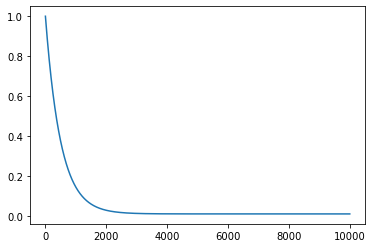

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cpu')

## 设置Replay Buffer

`random.sample()`多用于截取列表的指定长度的随机数，但是不会改变列表本身的排序。

In [7]:
import random
import numpy as np
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state, action, reward, next_state, 1 - done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [8]:
replay_buffer = ReplayBuffer(capacity=1000)

## DQN模型构建

In [9]:
import torch.nn as nn
class DQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DQN, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.layer = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
    
    def forward(self, x):
        return self.layer(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            q_value = self.forward(state)
            action = torch.argmax(q_value, dim=1).numpy()[0]
        else:
            action = random.randrange(self.num_outputs)
        return action

In [10]:
model = DQN(num_inputs=env.observation_space.shape[0], num_outputs=env.action_space.n)
model.to(device)

DQN(
  (layer): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

## 设置优化器

In [11]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

## 计算差分LOSS

In [12]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action)
    reward = torch.tensor(reward)
    next_state = torch.tensor(next_state, dtype=torch.float)
    done = torch.tensor(done)
            
    q_values = model(state)
    next_q_values = model(next_state)
    
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * done
    
    loss = (q_value - expected_q_value).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## 训练

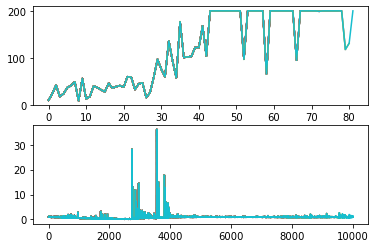

In [21]:
num_frames = 10000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0
state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.detach().numpy())
    
    if frame_idx % 200 == 0:
        plt.subplot(211)
        plt.plot(all_rewards)
        plt.subplot(212)
        plt.plot(losses)
        